In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
import tabulate
import csv
import pickle
from numpy import genfromtxt
from recsysNN_utils import *
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt

In [2]:
x_user = pd.read_csv("x_user.csv")
x_item = pd.read_csv("x_item.csv")
y = pd.read_csv("y.csv")

"""with open('umr_dict.pickle', 'rb') as f:
    # Load the dictionary from the file using pickle
    umr_dict = pickle.load(f)

print(umr_dict)"""

"with open('umr_dict.pickle', 'rb') as f:\n    # Load the dictionary from the file using pickle\n    umr_dict = pickle.load(f)\n\nprint(umr_dict)"

In [3]:
"""movie_dict = defaultdict(dict)
count = 0
with open('csv/small/movie_list.csv', newline='',encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in reader:
            if count == 0:
                count += 1  #skip header
                #print(line) print
            else:
                count += 1
                movie_id = int(line[0])
                movie_dict[movie_id]["title"] = line[1]
                movie_dict[movie_id]["genres"] = line[2]"""

'movie_dict = defaultdict(dict)\ncount = 0\nwith open(\'csv/small/movie_list.csv\', newline=\'\',encoding="utf8") as csvfile:\n        reader = csv.reader(csvfile, delimiter=\',\', quotechar=\'"\')\n        for line in reader:\n            if count == 0:\n                count += 1  #skip header\n                #print(line) print\n            else:\n                count += 1\n                movie_id = int(line[0])\n                movie_dict[movie_id]["title"] = line[1]\n                movie_dict[movie_id]["genres"] = line[2]'

In [4]:
print(f'train_user shape:{x_user.shape}')
print(f'train_item shape:{x_item.shape}')
print(f'y_train shape:{y.shape}')

train_user shape:(5630130, 17)
train_item shape:(5630130, 17)
y_train shape:(5630130, 1)


In [5]:
# scale training data
unscaled_train_item = x_item
unscaled_train_user = x_user
y_train_unscaled    = y

scalerItem = StandardScaler()#scalerItem = StandardScaler()
scalerItem.fit(x_item)#scalerItem.fit(item_train)
x_item = scalerItem.transform(x_item)#item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()#scalerUser = StandardScaler()
scalerUser.fit(x_user)#scalerUser.fit(user_train)
x_user = scalerUser.transform(x_user)#user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))#scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y.values.reshape(-1, 1))#scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y.values.reshape(-1, 1))#y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(unscaled_train_item, scalerItem.inverse_transform(x_item)))
print(np.allclose(unscaled_train_user, scalerUser.inverse_transform(x_user)))

True
True


In [6]:
x_train_item, item_test = train_test_split(x_item, train_size=0.80, shuffle=True, random_state=1)
x_train_user, user_test = train_test_split(x_user, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {x_train_item.shape}")
print(f"movie/item test data shape: {item_test.shape}")
print(f"movie/user training data shape: {x_train_user.shape}")
print(f"movie/user test data shape: {user_test.shape}")

movie/item training data shape: (4504104, 17)
movie/item test data shape: (1126026, 17)
movie/user training data shape: (4504104, 17)
movie/user test data shape: (1126026, 17)


In [7]:
num_user_features = x_train_user.shape[1] - 3
num_item_features = x_train_item.shape[1] - 1
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items

In [8]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
     
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),
    
])

item_NN = tf.keras.models.Sequential([
      
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),
    
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           40864       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           41376       ['input_2[0][0]']                
                                                                                              

In [9]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [10]:
tf.random.set_seed(1)
history = model.fit([x_train_user[:, u_s:], x_train_item[:, i_s:]], y_train, epochs=5, shuffle=True)

Epoch 1/5
140754/140754 [==============================] - 313s 2ms/step - loss: 0.1043
Epoch 2/5
140754/140754 [==============================] - 312s 2ms/step - loss: 0.0907
Epoch 3/5
140754/140754 [==============================] - 312s 2ms/step - loss: 0.0868
Epoch 4/5
140754/140754 [==============================] - 312s 2ms/step - loss: 0.0850
Epoch 5/5
140754/140754 [==============================] - 327s 2ms/step - loss: 0.0838


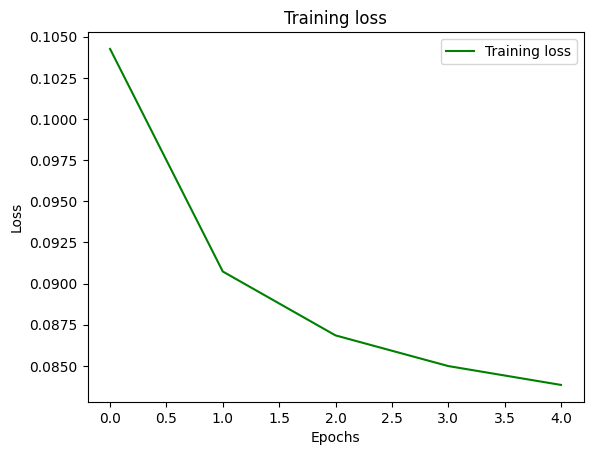

In [11]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

35189/35189 [==============================] - 54s 2ms/step - loss: 0.0836


0.0836101770401001

In [13]:
with open('nn_model.pickle', 'wb') as f:
    # Dump the dictionary into the file using pickle
    pickle.dump(model, f)

In [12]:
"""with open('deneme_model.pickle', 'wb') as f:
    # Dump the dictionary into the file using pickle
    pickle.dump(model, f)"""

In [18]:
new_user_id = 5000
new_rating_ave = 5.0
new_action = 1.0
new_adventure = 3.0
new_animation = 5.0
new_childrens = 4.0
new_comedy = 5.0
new_crime = 1.0
new_documentary = 2.0
new_drama = 4.5
new_fantasy = 3.0
new_horror = 1.0
new_mystery = 3.0
new_romance = 4.0
new_scifi = 2.0
new_thriller = 1.0
new_rating_count = 500
#user id,rating count,rating ave,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,***film-noir**Horror,**imax**,***musical***Mystery,Romance,Sci-Fi,Thriller***war***,***western***

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

In [19]:
item_vecs = genfromtxt('./csv/item_vecs.csv', delimiter=',')

In [20]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 20)

c:\Users\Burak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Burak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


26/26 [==============================] - 0s 2ms/step


y_p,movie id,rating ave,title,genres
4.8,2100,3.1,Splash (1984),Comedy|Fantasy|Romance
4.8,7373,3.4,Hellboy (2004),Action|Adventure|Fantasy|Horror
4.7,76251,3.7,Kick-Ass (2010),Action|Comedy
4.6,317,3.2,"Santa Clause, The (1994)",Comedy|Drama|Fantasy
4.6,64614,3.9,Gran Torino (2008),Crime|Drama
4.6,55820,3.9,No Country for Old Men (2007),Crime|Drama
4.5,4367,2.9,Lara Croft: Tomb Raider (2001),Action|Adventure
4.4,2947,3.8,Goldfinger (1964),Action|Adventure|Thriller
4.4,109374,3.8,"Grand Budapest Hotel, The (2014)",Comedy|Drama
4.4,2617,3.1,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller


In [24]:
uid = 1 
# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, unscaled_train_user.to_numpy(), item_vecs, umr_dict)

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display
sorted_user  = user_vecs[sorted_index]
sorted_y     = y_vecs[sorted_index]

#print sorted predictions for movies rated by the user
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, ivs, uvs, movie_dict, maxcount = 5000)

 1/26 [>.............................] - ETA: 1s

c:\Users\Burak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Burak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


26/26 [==============================] - 0s 2ms/step


y_p,y,user,user genre ave,movie rating ave,movie id,title,genres
4.6,5.0,1,"[4.4,4.8,4.8,4.4,4.3]",4.1,2761,"Iron Giant, The (1999)",Adventure|Animation|Children|Drama|Sci-Fi
4.6,5.0,1,"[4.4,4.4,4.2]",3.7,1625,"Game, The (1997)",Drama|Mystery|Thriller
4.6,5.0,1,"[4.3,4.4,4.2]",3.8,2947,Goldfinger (1964),Action|Adventure|Thriller
4.6,5.0,1,"[4.3,4.4,4.2]",3.5,151,Rob Roy (1995),Action|Drama|Romance|War
4.6,5.0,1,"[4.8,4.4,4.3]",3.8,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi
4.6,4.0,1,"[4.3,4.2]",3.4,1777,"Wedding Singer, The (1998)",Comedy|Romance
4.6,2.0,1,"[4.3,4.4,4.3,4.5,3.0,4.2]",3.1,2617,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller
4.5,5.0,1,"[4.3,4.4,4.3,4.2]",4.0,3703,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi|Thriller
4.5,5.0,1,"[4.4,4.4]",4.0,923,Citizen Kane (1941),Drama|Mystery
4.5,4.0,1,"[4.3,4.4]",3.3,1042,That Thing You Do! (1996),Comedy|Drama
